In [7]:
%reload_ext autoreload
%autoreload 2
%load_ext jupyter_black

import sys

sys.path.append("..")

from src.datautil2 import *
from src.modelutil import *
from src.trainutil import *
from src.metrics import *

import yaml

import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)

data_root = "../data"

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [2]:
with open("../config.yaml", "r") as stream:
    cfg = yaml.safe_load(stream)

# Data Handling
load data, build vocab, build dataset and dataloader

In [3]:
train_src_path = f"{data_root}/train.src"
train_tgt_path = f"{data_root}/train.tgt"

src_vocab, tgt_vocab = load_and_build_vocab(
    sentence_path=train_src_path,
    question_path=train_tgt_path,
    src_vocab_size=cfg["src_vocab_size"],
    tgt_vocab_size=cfg["tgt_vocab_size"],
)

print(len(src_vocab), len(tgt_vocab))

45000 28000


In [5]:
train_ds = SourceTargetDataset(
    data_dir=data_root,
    srcfile=data_root + "/train.src",
    tgtfile=data_root + "/train.tgt",
    src_vocab=src_vocab,
    tgt_vocab=tgt_vocab,
)

src_tokenizer = train_ds.src_tokenizer
tgt_tokenizer = train_ds.tgt_tokenizer

dev_ds = SourceTargetDataset(
    data_dir=data_root,
    srcfile=data_root + "/dev.src",
    tgtfile=data_root + "/dev.tgt",
    src_vocab=src_vocab,
    tgt_vocab=tgt_vocab,
)

In [6]:
token_ids, _ = src_tokenizer.encode(["hello world"])
print(token_ids)
print(src_tokenizer.decode(token_ids))

tensor([[42571,    65]])
['hello world']


In [57]:
collate_fn = CollateFn(
    src_tokenizer, tgt_tokenizer, cfg["src_max_seq"], cfg["tgt_max_seq"]
)
train_dl = DataLoader(train_ds, batch_size=3, collate_fn=collate_fn, shuffle=True)
valid_dl = DataLoader(dev_ds, batch_size=3, collate_fn=collate_fn, shuffle=False)
print(len(train_dl))
batch = next(iter(valid_dl))

23495


In [59]:
dev_ds[0:3]

(['the american football conference -lrb- afc -rrb- champion denver broncos defeated the national football conference -lrb- nfc -rrb- champion carolina panthers 24 -- 10 to earn their third super bowl title . \n',
  'the american football conference -lrb- afc -rrb- champion denver broncos defeated the national football conference -lrb- nfc -rrb- champion carolina panthers 24 -- 10 to earn their third super bowl title . \n',
  "the game was played on february 7 , 2016 , at levi 's stadium in the san francisco bay area at santa clara , california . \n"],
 ['which nfl team represented the afc at super bowl 50 ?\n',
  'which nfl team represented the nfc at super bowl 50 ?\n',
  'where did super bowl 50 take place ?\n'])

In [60]:
src_tokenizer.decode(batch[0])

['the american football conference -lrb- afc -rrb- champion denver broncos defeated the national football conference -lrb- <UNK> -rrb- champion carolina panthers 24 -- 10 to earn their third super bowl title . <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>',
 'the american football conference -lrb- afc -rrb- champion denver broncos defeated the national football conference -lrb- <UNK> -rrb- champion carolina panthers 24 -- 10 to earn their third super bowl title . <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>',
 "the game was played on february 7 , 2016 , at levi 's stadium in the san francisco bay area at santa clara , california . <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>"]

In [61]:
tgt_tokenizer.decode(batch[1])

['which nfl team represented the <UNK> at super bowl 50 ? <EOS> <PAD>',
 'which nfl team represented the <UNK> at super bowl 50 ? <EOS> <PAD>',
 'where did super bowl 50 take place ? <EOS> <PAD> <PAD> <PAD> <PAD>']

In [51]:
for src, tgt, src_mask, tgt_mask in train_dl:
    print(
        f"src: {src.shape}, tgt: {tgt.shape}, src_mask: {src_mask.shape}, tgt_mask: {tgt_mask.shape}"
    )
    break

src: torch.Size([3, 38]), tgt: torch.Size([3, 18]), src_mask: torch.Size([3, 38]), tgt_mask: torch.Size([3, 18])


# Misc Utils

In [28]:
def plot_attention(attention, src, tgt):
    src = src.split()[: attention.size(0)]
    tgt = tgt.split()

    fig, ax = plt.subplots(figsize=(20, 8))
    heatmap = ax.pcolor(attention.T.cpu(), cmap=plt.cm.Blues, alpha=0.9)

    xticks = range(0, len(src))
    ax.set_xticks(xticks, minor=False)  # major ticks
    ax.set_xticklabels(src, minor=False, rotation=45)  # labels should be 'unicode'

    yticks = range(0, len(tgt))
    ax.set_yticks(yticks, minor=False)
    ax.set_yticklabels(tgt, minor=False)  # labels should be 'unicode'

    ax.set_xlabel("source")
    ax.set_ylabel("target")

    ax.grid(False)

    # Save Figure
    plt.show()
    fig.savefig("attention.png")

# Model Building

In [62]:
cfg["experiment_name"] = "batchwise-max-seq"
checkpoint_dir = f"{cfg['checkpoint_dir']}/{cfg['experiment_name']}"
history_dir = f"{checkpoint_dir}/history"
cfg["max_epoch"] = 15

model = Seq2Seq(
    src_vocab_size=len(src_vocab),
    tgt_vocab_size=len(tgt_vocab),
    src_embedding_vector=None,
    tgt_embedding_vector=None,
    tgt_pad_index=tgt_vocab["<PAD>"],
    tgt_sos_index=tgt_vocab["<SOS>"],
    tgt_eos_index=tgt_vocab["<EOS>"],
    hidden_size=cfg["hidden_size"],
    bidirectional=cfg["bidirectional"],
    num_layers=cfg["num_layers"],
    src_embedding_size=cfg["src_embedding_size"],
    tgt_embedding_size=cfg["tgt_embedding_size"],
    dropout=cfg["dropout"],
)

optimizer, lr_scheduler = init_optimizer_scheduler(model, cfg)

history = fit(
    model=model,
    optimizer=optimizer,
    train_dl=train_dl,
    valid_dl=valid_dl,
    cfg=cfg,
    checkpoint_dir=checkpoint_dir,
    max_step=-1,
    epoch=0,
    lr_scheduler=lr_scheduler,
    ignore_index=tgt_vocab["<PAD>"],
)

INFO:src.trainutil:checkpoint_dir: ./checkpoints/batchwise-max-seq


Training...
	Step: 0/23495, Loss: 10.230828285217285
	Step: 200/23495, Loss: 7.503327369689941
	Step: 400/23495, Loss: 6.333773612976074
	Step: 600/23495, Loss: 6.459737777709961
	Step: 800/23495, Loss: 5.419632911682129
	Step: 1000/23495, Loss: 5.629872798919678


KeyboardInterrupt: 

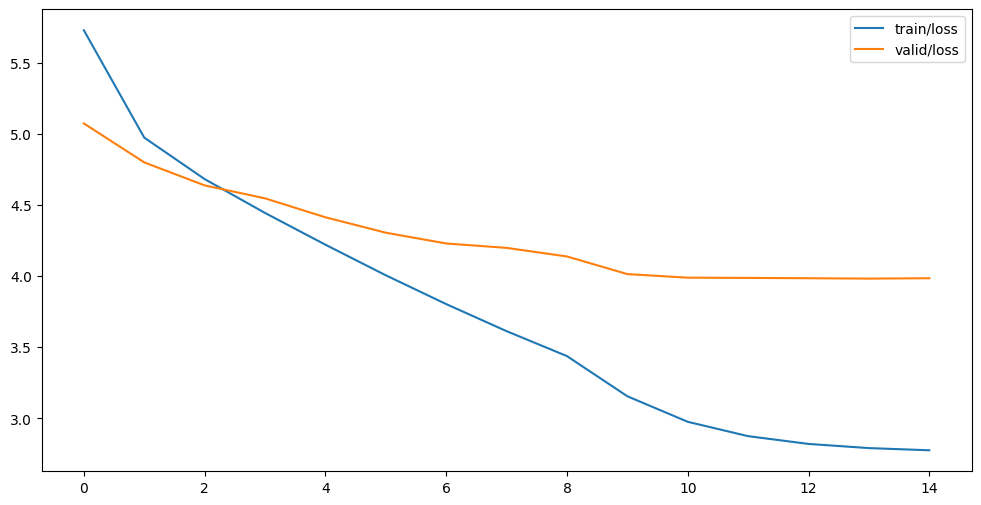

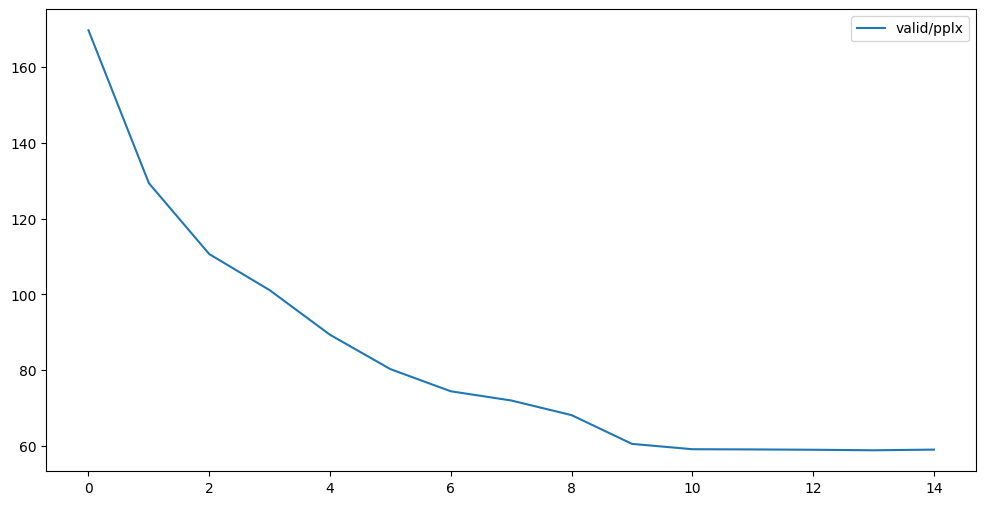

In [39]:
save_history(history, cfg, history_dir, save_graph=True)

# Generation & Visualization

In [3]:
checkpoint_dir = Path("checkpoints/debug1")
with open(checkpoint_dir / "history/config.yaml", "r") as stream:
    cfg = yaml.safe_load(stream)
    


In [8]:
src_tokenizer, tgt_tokenizer = load_tokenizers(checkpoint_dir)
src_vocab = src_tokenizer.vocab
tgt_vocab = tgt_tokenizer.vocab

In [22]:
model = init_model(cfg, src_vocab, tgt_vocab)
model, _, _, epoch = load_checkpoint(model, checkpoint_dir / "model_best.pt")

INFO:src.trainutil:🎉 Loaded existing model. Epoch: 14


In [29]:
source = "i have nothing"
hyp, attn = generate(model, source, src_tokenizer, tgt_tokenizer, cfg, method="greedy")
print("hypothesis:", hyp[0])
# plot_attention(attn.squeeze(0), source, hyp[0])

hypothesis: what did the <UNK> of the <UNK> have ?


In [33]:
%%time
with open(f"{data_root}/dev.src") as srcfile:
    sources = srcfile.readlines()

with open(f"{data_root}/dev.tgt") as tgtfile:
    references = tgtfile.readlines()

hypotheses = []
for source in sources:
    hyp, _ = generate(model, source, src_tokenizer, tgt_tokenizer, cfg, method="greedy")
    hypotheses.append(hyp[0])

metrics = compute_metrics(hypotheses, references)
metrics = {k: v * 100 for k, v in metrics.items()}
metrics

CPU times: user 1min 46s, sys: 163 ms, total: 1min 47s
Wall time: 1min 47s


{'bleu1': 26.15172266960144,
 'bleu2': 12.592239677906036,
 'bleu3': 6.95580467581749,
 'bleu4': 4.079585149884224,
 'rougeL': 23.24240505695343}